# <center>Домашнее задание № 5 

### Предобработка данных и логистическая регрессия для задачи бинарной классификации

In [1]:
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline

## Описание датасета

Задача: по 38 признакам, связанных с заявкой на грант (область исследований учёных, информация по их академическому бэкграунду, размер гранта, область, в которой он выдаётся) предсказать, будет ли заявка принята. Датасет включает в себя информацию по 6000 заявкам на гранты, которые были поданы в университете Мельбурна в период с 2004 по 2008 год.

Полную версию данных с большим количеством признаков можно найти на https://www.kaggle.com/c/unimelb.

Выделим из датасета целевую переменную Grant.Status и обозначим её за y
Теперь X обозначает обучающую выборку, y - ответы на ней

In [2]:
data = pd.read_csv('data.csv')
data.shape

(6000, 39)

In [3]:
X = data.drop('Grant.Status', 1)
y = data['Grant.Status']

## Теория по логистической регрессии

После осознания того, какую именно задачу требуется решить на этих данных, следующим шагом при реальном анализе был бы подбор подходящего метода. В данном задании выбор метода было произведён за вас, это логистическая регрессия. Кратко напомним вам используемую модель.

Логистическая регрессия предсказывает вероятности принадлежности объекта к каждому классу. Сумма ответов логистической регрессии на одном объекте для всех классов равна единице.

$$ \sum_{k=1}^K \pi_{ik} = 1, \quad \pi_k \equiv P\,(y_i = k \mid x_i, \theta), $$

где:
- $\pi_{ik}$ - вероятность принадлежности объекта $x_i$ из выборки $X$ к классу $k$
- $\theta$ - внутренние параметры алгоритма, которые настраиваются в процессе обучения, в случае логистической регрессии - $w, b$

Из этого свойства модели в случае бинарной классификации требуется вычислить лишь вероятность принадлежности объекта к одному из классов (вторая вычисляется из условия нормировки вероятностей). Эта вероятность вычисляется, используя логистическую функцию:

$$ P\,(y_i = 1 \mid x_i, \theta) = \frac{1}{1 + \exp(-w^T x_i-b)} $$

Параметры $w$ и $b$ находятся, как решения следующей задачи оптимизации (указаны функционалы с L1 и L2 регуляризацией, с которыми вы познакомились в предыдущих заданиях):

L2-regularization:

$$ Q(X, y, \theta) = \frac{1}{2} w^T w + C \sum_{i=1}^l \log ( 1 + \exp(-y_i (w^T x_i + b ) ) ) \longrightarrow \min\limits_{w,b} $$

L1-regularization:

$$ Q(X, y, \theta) = \sum_{d=1}^D |w_d| + C \sum_{i=1}^l \log ( 1 + \exp(-y_i (w^T x_i + b ) ) ) \longrightarrow \min\limits_{w,b} $$

$C$ - это стандартный гиперпараметр модели, который регулирует то, насколько сильно мы позволяем модели подстраиваться под данные.

## Предобработка данных

Из свойств данной модели следует, что:
- все $X$ должны быть числовыми данными (в случае наличия среди них категорий, их требуется некоторым способом преобразовать в вещественные числа)
- среди $X$ не должно быть пропущенных значений (т.е. все пропущенные значения перед применением модели следует каким-то образом заполнить)

Поэтому базовым этапом в предобработке любого датасета для логистической регрессии будет кодирование категориальных признаков, а так же удаление или интерпретация пропущенных значений (при наличии того или другого).

In [4]:
data.head()

,Grant.Status,Sponsor.Code,Grant.Category.Code,Contract.Value.Band...see.note.A,RFCD.Code.1,RFCD.Percentage.1,RFCD.Code.2,RFCD.Percentage.2,RFCD.Code.3,RFCD.Percentage.3,...,Dept.No..1,Faculty.No..1,With.PHD.1,No..of.Years.in.Uni.at.Time.of.Grant.1,Number.of.Successful.Grant.1,Number.of.Unsuccessful.Grant.1,A..1,A.1,B.1,C.1
0,1,21A,50A,A,230202.0,50.0,230203.0,30.0,230204.0,20.0,...,3098.0,31.0,Yes,>=0 to 5,2.0,0.0,0.0,4.0,2.0,0.0
1,1,4D,10A,D,320801.0,100.0,0.0,0.0,0.0,0.0,...,2553.0,25.0,Yes,>=0 to 5,3.0,1.0,0.0,2.0,0.0,0.0
2,0,NaN,NaN,NaN,320602.0,50.0,321004.0,30.0,321015.0,20.0,...,2813.0,25.0,NaN,Less than 0,1.0,5.0,0.0,7.0,2.0,0.0
3,0,51C,20C,A,291503.0,60.0,321402.0,40.0,0.0,0.0,...,2553.0,25.0,NaN,more than 15,2.0,1.0,5.0,6.0,9.0,1.0
4,0,24D,30B,NaN,380107.0,100.0,0.0,0.0,0.0,0.0,...,2923.0,25.0,NaN,Less than 0,0.0,2.0,0.0,0.0,0.0,0.0


Видно, что в датасете есть как числовые, так и категориальные признаки. Получим списки их названий:

In [5]:
numeric_cols = ['RFCD.Percentage.1', 'RFCD.Percentage.2', 'RFCD.Percentage.3', 
                'RFCD.Percentage.4', 'RFCD.Percentage.5',
                'SEO.Percentage.1', 'SEO.Percentage.2', 'SEO.Percentage.3',
                'SEO.Percentage.4', 'SEO.Percentage.5',
                'Year.of.Birth.1', 'Number.of.Successful.Grant.1', 'Number.of.Unsuccessful.Grant.1']
categorical_cols = list(set(X.columns.values.tolist()) - set(numeric_cols))

Также в нём присутствуют пропущенные значения. Очевидны решением будет исключение всех данных, у которых пропущено хотя бы одно значение. Сделаем это:

In [6]:
data.dropna().shape

(213, 39)

Видно, что тогда мы выбросим почти все данные, и такой метод решения в данном случае не сработает.

Пропущенные значения можно так же интерпретировать, для этого существует несколько способов, они различаются для категориальных и вещественных признаков.

Для вещественных признаков:
- заменить на 0 (данный признак давать вклад в предсказание для данного объекта не будет)
- заменить на среднее (каждый пропущенный признак будет давать такой же вклад, как и среднее значение признака на датасете)

Для категориальных:
- интерпретировать пропущенное значение, как ещё одну категорию (данный способ является самым естественным, так как в случае категорий у нас есть уникальная возможность не потерять информацию о наличии пропущенных значений; обратите внимание, что в случае вещественных признаков данная информация неизбежно теряется)

##  Задание 1. Обработка пропущенных значений.
1. Заполните пропущенные вещественные значения в X нулями и средними по столбцам, назовите полученные датафреймы X_real_zeros и X_real_mean соответственно. Для подсчёта средних используйте описанную ниже функцию calculate_means, которой требуется передать на вход вешественные признаки из исходного датафрейма.
2. Все категориальные признаки в X преобразуйте в строки, пропущенные значения требуется также преобразовать в какие-либо строки, которые не являются категориями (например, 'NA'), полученный датафрейм назовите X_cat.

Воспользуйтесь методом fillna( )

In [7]:
def calculate_means(numeric_data):
    means = np.zeros(numeric_data.shape[1])
    for j in range(numeric_data.shape[1]):
        to_sum = numeric_data.iloc[:,j]
        indices = np.nonzero(~numeric_data.iloc[:,j].isnull())[0]
        correction = np.amax(to_sum[indices])
        to_sum /= correction
        for i in indices:
            means[j] += to_sum[i]
        means[j] /= indices.size
        means[j] *= correction
    return pd.Series(means, numeric_data.columns)

In [8]:
X_real_zeros=X[numeric_cols].fillna(0)
X_real_mean=X[numeric_cols].fillna(calculate_means(data[numeric_cols]))
X_cat = X[categorical_cols].fillna('NA', axis=0)
X_cat.applymap(str);

## Преобразование категориальных признаков.

В предыдущей ячейке мы разделили наш датасет ещё на две части: в одной присутствуют только вещественные признаки, в другой только категориальные. Это понадобится нам для раздельной последующей обработке этих данных, а так же для сравнения качества работы тех или иных методов.

Для использования модели регрессии требуется преобразовать категориальные признаки в вещественные. Рассмотрим основной способ преоборазования категориальных признаков в вещественные: one-hot encoding. Его идея заключается в том, что мы преобразуем категориальный признак при помощи бинарного кода: каждой категории ставим в соответствие набор из нулей и единиц.

Посмотрим, как данный метод работает на простом наборе данных.

In [9]:
from sklearn.linear_model import LogisticRegression as LR
from sklearn.feature_extraction import DictVectorizer as DV

categorial_data = pd.DataFrame({'sex': ['male', 'female', 'male', 'female'], 
                                'nationality': ['American', 'European', 'Asian', 'European']})
print('Исходные данные:\n')
print(categorial_data)
encoder = DV(sparse = False)
encoded_data = encoder.fit_transform(categorial_data.T.to_dict().values())
print('\nЗакодированные данные:\n')
print(encoded_data)

Исходные данные:

  nationality     sex
0    American    male
1    European  female
2       Asian    male
3    European  female

Закодированные данные:

[[1. 0. 0. 0. 1.]
 [0. 0. 1. 1. 0.]
 [0. 1. 0. 0. 1.]
 [0. 0. 1. 1. 0.]]


Как видно, в первые три колонки оказалась закодированна информация о стране, а во вторые две - о поле. При этом для совпадающих элементов выборки строки будут полностью совпадать. Также из примера видно, что кодирование признаков сильно увеличивает их количество, но полностью сохраняет информацию, в том числе о наличии пропущенных значений (их наличие просто становится одним из бинарных признаков в преобразованных данных).

Теперь применим one-hot encoding к категориальным признакам из исходного датасета. Обратите внимание на общий для всех методов преобработки данных интерфейс. Функция

    encoder.fit_transform(X)
    
позволяет вычислить необходимые параметры преобразования, впоследствии к новым данным можно уже применять функцию

    encoder.transform(X)
    
Очень важно применять одинаковое преобразование как к обучающим, так и тестовым данным, потому что в противном случае вы получите непредсказуемые, и, скорее всего, плохие результаты. В частности, если вы отдельно закодируете обучающую и тестовую выборку, то получите вообще говоря разные коды для одних и тех же признаков, и ваше решение работать не будет.

Также параметры многих преобразований (например, рассмотренное ниже масштабирование) нельзя вычислять одновременно на данных из обучения и теста, потому что иначе подсчитанные на тесте метрики качества будут давать смещённые оценки на качество работы алгоритма. Кодирование категориальных признаков не считает на обучающей выборке никаких параметров, поэтому его можно применять сразу к всему датасету.

In [10]:
encoder = DV(sparse = False)
X_cat_oh = encoder.fit_transform(X_cat.T.to_dict().values())

Для построения метрики качества по результату обучения требуется разделить исходный датасет на обучающую и тестовую выборки.


In [11]:
from sklearn.model_selection import train_test_split

X_train_real_zeros, X_test_real_zeros, y_train, y_test = train_test_split(X_real_zeros, y, test_size=0.3, random_state=0)

X_train_real_mean, X_test_real_mean = train_test_split(X_real_mean, test_size=0.3, random_state=0)

X_train_cat_oh,X_test_cat_oh = train_test_split(X_cat_oh, test_size=0.3, random_state=0)

## Описание классов

Итак, мы получили первые наборы данных, для которых выполнены оба ограничения логистической регрессии на входные данные. Обучим на них регрессию, используя имеющийся в библиотеке sklearn функционал по подбору гиперпараметров модели
    
    optimizer = GridSearchCV(estimator, param_grid)

где:
- estimator - обучающий алгоритм, для которого будет производиться подбор параметров
- param_grid - словарь параметров, ключами которого являются строки-названия, которые передаются алгоритму estimator, а значения - набор параметров для перебора

Данный класс выполняет кросс-валидацию обучающей выборки для каждого набора параметров и находит те, на которых алгоритм работает лучше всего. Этот метод позволяет настраивать гиперпараметры по обучающей выборке, избегая переобучения. Некоторые опциональные параметры вызова данного класса, которые нам понадобятся:
- scoring - функционал качества, максимум которого ищется кросс валидацией, по умолчанию используется функция score() класса esimator
- n_jobs - позволяет ускорить кросс-валидацию, выполняя её параллельно, число определяет количество одновременно запущенных задач
- cv - количество фолдов, на которые разбивается выборка при кросс-валидации

После инициализации класса GridSearchCV, процесс подбора параметров запускается следующим методом:

    optimizer.fit(X, y)
    
На выходе для получения предсказаний можно пользоваться функцией

    optimizer.predict(X)
    
для меток или

    optimizer.predict_proba(X)
    
для вероятностей (в случае использования логистической регрессии).
    
Также можно напрямую получить оптимальный класс estimator и оптимальные параметры, так как они является атрибутами класса GridSearchCV:
- best\_estimator\_ - лучший алгоритм
- best\_params\_ - лучший набор параметров

Класс логистической регрессии выглядит следующим образом:

    estimator = LogisticRegression(penalty)
   
где penalty принимает либо значение 'l2', либо 'l1'. По умолчанию устанавливается значение 'l2', и везде в задании, если об этом не оговорено особо, предполагается использование логистической регрессии с L2-регуляризацией.

## Задание 2. Сравнение способов заполнения вещественных пропущенных значений.

Составьте две обучающие выборки из вещественных и категориальных признаков: в одной вещественные признаки, где пропущенные значения заполнены нулями, в другой - средними. Рекомендуется записывать в выборки сначала вещественные, а потом категориальные признаки.

Для объединения  выборорк можно использовать np.hstack () или np.concatenate()

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

def plot_scores(optimizer):
    scores = [[item[0]['C'], 
               item[1], 
               (np.sum((item[2]-item[1])**2)/(item[2].size-1))**0.5] for item in optimizer.grid_scores_]
    scores = np.array(scores)
    plt.semilogx(scores[:,0], scores[:,1])
    plt.fill_between(scores[:,0], scores[:,1]-scores[:,2], 
                                  scores[:,1]+scores[:,2], alpha=0.3)
    plt.show()

Xtrainzero = np.hstack((X_train_real_zeros,X_train_cat_oh)) 
Xtrainmean = np.hstack((X_train_real_mean,X_train_cat_oh))
Xtestzero = np.hstack((X_test_real_zeros,X_test_cat_oh)) 
Xtestmean = np.hstack((X_test_real_mean,X_test_cat_oh))

Обучите на них логистическую регрессию, подбирая параметры из заданной сетки param_grid по методу кросс-валидации с числом фолдов cv=3. В качестве оптимизируемой функции используйте заданную по умолчанию.


In [13]:
param_grid = {'C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10]}

LR = LogisticRegression(random_state = 0)

gridCVZ = GridSearchCV(LR, param_grid, cv = 3)
gridCVM = GridSearchCV(LR, param_grid, cv = 3)

gridCVZ.fit(Xtrainzero, y_train)
gridCVM.fit(Xtrainmean, y_train);

C:\Anaconda\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


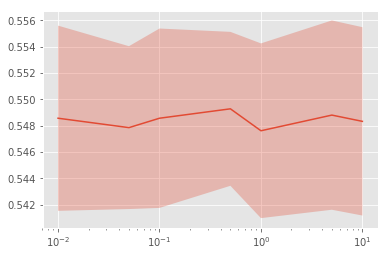

In [14]:
plot_scores(gridCVZ)

C:\Anaconda\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


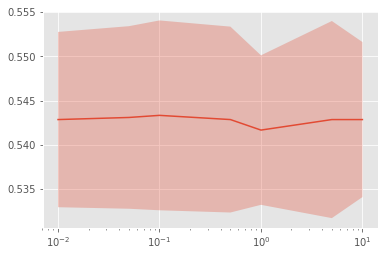

In [15]:
plot_scores(gridCVM)

Выведите лучшее полученное значение метрики качеста и соответствующее значение гиперпараметра С 

In [16]:
print("Результат для X_train_zero:best score - {}, best parameters - {}".format(gridCVZ.best_score_, gridCVZ.best_params_))
print("Результат для X_train_mean:best score - {}, best parameters - {}".format(gridCVM.best_score_, gridCVM.best_params_))

Результат для X_train_zero:best score - 0.5492857142857143, best parameters - {'C': 0.5}
Результат для X_train_mean:best score - 0.5433333333333333, best parameters - {'C': 0.1}


## Масштабирование вещественных признаков.

Попробуем как-то улучшить качество классификации. Для этого посмотрим на сами данные:

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: 'pandas.tools.plotting.scatter_matrix' is deprecated, import 'pandas.plotting.scatter_matrix' instead.
  """


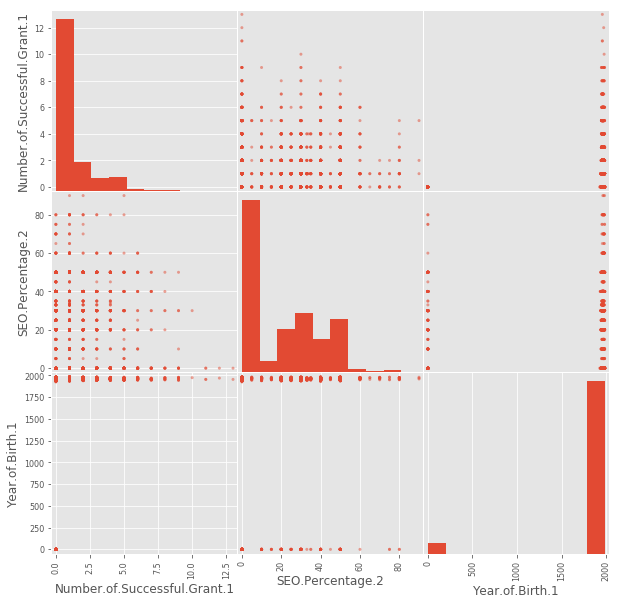

In [17]:
from pandas.tools.plotting import scatter_matrix

data_numeric = pd.DataFrame(X_train_real_zeros, columns=numeric_cols)
list_cols = ['Number.of.Successful.Grant.1', 'SEO.Percentage.2', 'Year.of.Birth.1']
scatter_matrix(data_numeric[list_cols], alpha=0.5, figsize=(10, 10))
plt.show()

Как видно из графиков, разные признаки очень сильно отличаются друг от друга по модулю значений (обратите внимание на диапазоны значений осей x и y). В случае обычной регрессии это никак не влияет на качество обучаемой модели, т.к. у меньших по модулю признаков будут большие веса, но при использовании регуляризации, которая штрафует модель за большие веса, регрессия, как правило, начинает работать хуже.

В таких случаях всегда рекомендуется делать стандартизацию (масштабирование) признаков, для того чтобы они меньше отличались друг друга по модулю, но при этом не нарушались никакие другие свойства признакового пространства. При этом даже если итоговое качество модели на тесте уменьшается, это повышает её интерпретабельность, потому что новые веса имеют смысл "значимости" данного признака для итоговой классификации.

Стандартизация осуществляется посредством вычета из каждого признака среднего значения и нормировки на выборочное стандартное отклонение:

$$ x^{scaled}_{id} = \dfrac{x_{id} - \mu_d}{\sigma_d}, \quad \mu_d = \frac{1}{N} \sum_{i=1}^l x_{id}, \quad \sigma_d = \sqrt{\frac{1}{N-1} \sum_{i=1}^l (x_{id} - \mu_d)^2} $$

## Задание 3. Масштабирование вещественных признаков.

Примените масштабирование вещественных признаков для обучающих и тестовых выборок X_train_real_zeros и X_test_real_zeros, используя класс 

        StandardScaler
   
   и методы 

        StandardScaler.fit_transform(...)
        StandardScaler.transform(...)


In [18]:
from sklearn.preprocessing import StandardScaler

scaler_train = StandardScaler()
scaler_train.fit_transform(X_train_real_zeros, y_train)

X_train_real_zerosca=scaler_train.transform(X_train_real_zeros)
X_test_real_zerosca=scaler_train.transform(X_test_real_zeros)

## Сравнение признаковых пространств.

Построим такие же графики для преобразованных данных:

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: 'pandas.tools.plotting.scatter_matrix' is deprecated, import 'pandas.plotting.scatter_matrix' instead.
  This is separate from the ipykernel package so we can avoid doing imports until


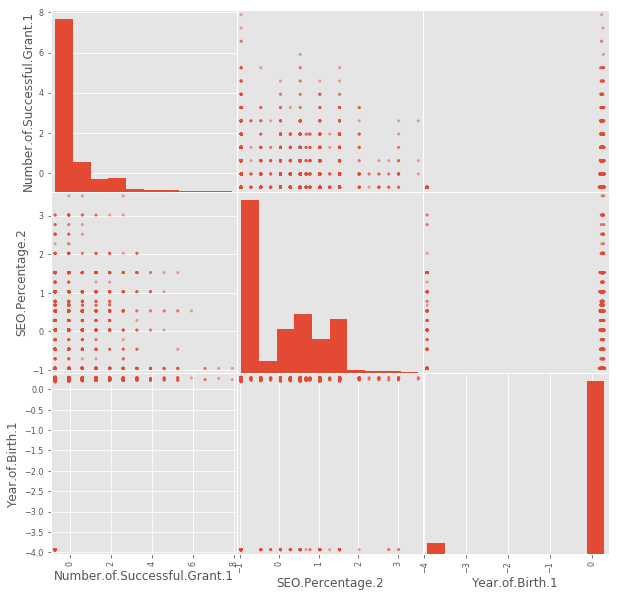

In [19]:
data_numeric_scaled = pd.DataFrame(X_train_real_zerosca, columns=numeric_cols)
list_cols = ['Number.of.Successful.Grant.1', 'SEO.Percentage.2', 'Year.of.Birth.1']
scatter_matrix(data_numeric_scaled[list_cols], alpha=0.5, figsize=(10, 10))
plt.show()

Как видно из графиков, мы не поменяли свойства признакового пространства: гистограммы распределений значений признаков, как и их scatter-plots, выглядят так же, как и до нормировки, но при этом все значения теперь находятся примерно в одном диапазоне, тем самым повышая интерпретабельность результатов, а также лучше сочетаясь с идеологией регуляризации.

## Задание 4. Сравнение качества классификации до и после масштабирования вещественных признаков.
1. Обучите ещё раз регрессию и гиперпараметры на новых признаках, объединив их с закодированными категориальными.
2. Выведите лучшее полученное значение метрики качеста и соответствующее значение гиперпараметра С 

In [20]:
Xtrainzerosca = np.hstack((X_train_real_zerosca,X_train_cat_oh)) 
Xtestzerosca = np.hstack((X_test_real_zerosca,X_test_cat_oh))

In [21]:
param_grid = {'C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10]}

gridCV = GridSearchCV(LR, param_grid, cv = 3)

gridCV.fit(Xtrainzerosca, y_train);

C:\Anaconda\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


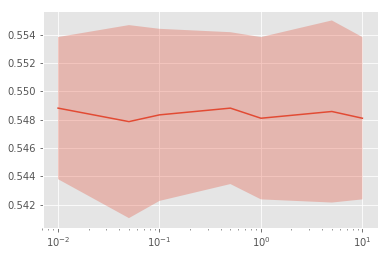

In [22]:
plot_scores(gridCV)

In [23]:
print("Результат для X_train_zero:best score - {}, best parameters - {}".format(gridCV.best_score_, gridCV.best_params_))

Результат для X_train_zero:best score - 0.5488095238095239, best parameters - {'C': 0.01}


Исследуя результат, можно сказать, что метрика стала немножко хуже. Но зато теперь видно, что С влияет на неё меньше и сами данные теперь более равномерно будут участвувать в обучении.